# Statewide Bicycle Crash Analysis in North Carolina (2007-2018)

In [50]:
# Dependencies and Setup
#%matplotlib notebook
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
from pprint import pprint

import requests
import json
import time
import gmaps
#from us import states
from config import gkey

In [183]:
# Read the csv file containing the Bicycle Crash data for North Carolina
input_file_path = "Resources/bicycle-crash-data-chapel-hill-region.csv"
crash_data = pd.read_csv(input_file_path, delimiter = ";")

# View the csv file containing the Bicycle Crash data for North Carolina
crash_data

# There are 11266 records in 55 columns

,geo_point_2d,Ambulance,BikeAge,BikeAgeGrp,BikeAlcDrg,BikeAlcFlg,BikeDir,BikeInjury,BikePos,BikeRace,...,RdConditio,RdConfig,RdDefects,RdFeature,RdSurface,RuralUrban,SpeedLimit,TraffCntrl,Weather,Workzone
0,"33.9437020597,-78.3493385901",Yes,70,70+,No,No,With Traffic,C: Possible Injury,Travel Lane,White,...,Dry,"Two-Way, Not Divided",None,No Special Feature,Coarse Asphalt,Rural,40 - 45 MPH,No Control Present,Clear,No
1,"35.3217726,-79.0388423701",Yes,8,6-10,No,No,With Traffic,C: Possible Injury,Travel Lane,White,...,Dry,"Two-Way, Not Divided",None,T-Intersection,Smooth Asphalt,Rural,50 - 55 MPH,Stop Sign,Clear,No
2,"35.77105009,-78.6073184803",Yes,13,11-15,No,No,Facing Traffic,A: Suspected Serious Injury,Travel Lane,Black,...,Dry,"Two-Way, Divided, Positive Median Barrier",None,No Special Feature,Coarse Asphalt,Urban,30 - 35 MPH,Stop And Go Signal,Cloudy,No
3,"35.9394515202,-77.7953706304",Yes,52,50-59,No,No,Facing Traffic,C: Possible Injury,Travel Lane,Black,...,Dry,"One-Way, Not Divided",None,Four-Way Intersection,Coarse Asphalt,Urban,30 - 35 MPH,Stop And Go Signal,Clear,No
4,"36.0927628197,-80.2653764398",Yes,27,25-29,No,No,Not Applicable,C: Possible Injury,Non-Roadway,White,...,Dry,"Two-Way, Not Divided",None,No Special Feature,Smooth Asphalt,Urban,30 - 35 MPH,"Double Yellow Line, No Passing Zone",Clear,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11261,"34.2546581498,-77.9197554903",Yes,26,25-29,No,No,Facing Traffic,C: Possible Injury,Travel Lane,White,...,Dry,"Two-Way, Not Divided",None,No Special Feature,Coarse Asphalt,Urban,30 - 35 MPH,Stop And Go Signal,Clear,No
11262,"35.2123611203,-80.7913412696",Yes,20,20-24,No,No,Facing Traffic,C: Possible Injury,Sidewalk / Crosswalk / Driveway Crossing,Black,...,Dry,"Two-Way, Not Divided",None,No Special Feature,Smooth Asphalt,Urban,30 - 35 MPH,No Control Present,Cloudy,No
11263,"35.64331907,-80.4828223001",Yes,11,11-15,No,No,Facing Traffic,C: Possible Injury,Travel Lane,Unknown/Missing,...,Dry,"Two-Way, Divided, Unprotected Median",None,No Special Feature,Smooth Asphalt,Urban,40 - 45 MPH,No Control Present,Clear,No
11264,"34.1935523204,-77.9356315301",No,60,60-69,No,No,With Traffic,C: Possible Injury,Travel Lane,White,...,Dry,"Two-Way, Not Divided",None,No Special Feature,Coarse Asphalt,Urban,40 - 45 MPH,No Control Present,Clear,No


### Cleaning the Crash Group data

In [52]:
# Clear rows with missing data in any column
clean_crash_data = crash_data.dropna(how='any')
clean_crash_data
# None of the records were deleted so none of the rows have missing data

,geo_point_2d,Ambulance,BikeAge,BikeAgeGrp,BikeAlcDrg,BikeAlcFlg,BikeDir,BikeInjury,BikePos,BikeRace,...,RdConditio,RdConfig,RdDefects,RdFeature,RdSurface,RuralUrban,SpeedLimit,TraffCntrl,Weather,Workzone
0,"33.9437020597,-78.3493385901",Yes,70,70+,No,No,With Traffic,C: Possible Injury,Travel Lane,White,...,Dry,"Two-Way, Not Divided",None,No Special Feature,Coarse Asphalt,Rural,40 - 45 MPH,No Control Present,Clear,No
1,"35.3217726,-79.0388423701",Yes,8,6-10,No,No,With Traffic,C: Possible Injury,Travel Lane,White,...,Dry,"Two-Way, Not Divided",None,T-Intersection,Smooth Asphalt,Rural,50 - 55 MPH,Stop Sign,Clear,No
2,"35.77105009,-78.6073184803",Yes,13,11-15,No,No,Facing Traffic,A: Suspected Serious Injury,Travel Lane,Black,...,Dry,"Two-Way, Divided, Positive Median Barrier",None,No Special Feature,Coarse Asphalt,Urban,30 - 35 MPH,Stop And Go Signal,Cloudy,No
3,"35.9394515202,-77.7953706304",Yes,52,50-59,No,No,Facing Traffic,C: Possible Injury,Travel Lane,Black,...,Dry,"One-Way, Not Divided",None,Four-Way Intersection,Coarse Asphalt,Urban,30 - 35 MPH,Stop And Go Signal,Clear,No
4,"36.0927628197,-80.2653764398",Yes,27,25-29,No,No,Not Applicable,C: Possible Injury,Non-Roadway,White,...,Dry,"Two-Way, Not Divided",None,No Special Feature,Smooth Asphalt,Urban,30 - 35 MPH,"Double Yellow Line, No Passing Zone",Clear,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11261,"34.2546581498,-77.9197554903",Yes,26,25-29,No,No,Facing Traffic,C: Possible Injury,Travel Lane,White,...,Dry,"Two-Way, Not Divided",None,No Special Feature,Coarse Asphalt,Urban,30 - 35 MPH,Stop And Go Signal,Clear,No
11262,"35.2123611203,-80.7913412696",Yes,20,20-24,No,No,Facing Traffic,C: Possible Injury,Sidewalk / Crosswalk / Driveway Crossing,Black,...,Dry,"Two-Way, Not Divided",None,No Special Feature,Smooth Asphalt,Urban,30 - 35 MPH,No Control Present,Cloudy,No
11263,"35.64331907,-80.4828223001",Yes,11,11-15,No,No,Facing Traffic,C: Possible Injury,Travel Lane,Unknown/Missing,...,Dry,"Two-Way, Divided, Unprotected Median",None,No Special Feature,Smooth Asphalt,Urban,40 - 45 MPH,No Control Present,Clear,No
11264,"34.1935523204,-77.9356315301",No,60,60-69,No,No,With Traffic,C: Possible Injury,Travel Lane,White,...,Dry,"Two-Way, Not Divided",None,No Special Feature,Coarse Asphalt,Urban,40 - 45 MPH,No Control Present,Clear,No


## Clean the Crash Group Data

In [53]:
# Crashes by Crash Gpr
crashes_by_crashgrp = crash_data.groupby(["CrashGrp"])["geo_point_2d"].count()
crashes_by_crashgrp

# Needs cleaning

CrashGrp
Backing Vehicle                                               88
Bicyclist Failed to Yield - Midblock                         689
Bicyclist Failed to Yield - Sign-Controlled Intersection     642
Bicyclist Failed to Yield - Signalized Intersection          478
Bicyclist Failed to Yield—Midblock                            50
Bicyclist Failed to Yield—Sign-Controlled Intersection        37
Bicyclist Failed to Yield—Signalized Intersection             52
Bicyclist Left Turn / Merge                                  461
Bicyclist Left Turn/Merge                                     42
Bicyclist Overtaking Motorist                                232
Bicyclist Right Turn / Merge                                 128
Bicyclist Right Turn/Merge                                     6
Crossing Paths - Other Circumstances                         616
Crossing Paths—Other Circumstances                            58
Head-On                                                      300
Loss of Control 

In [62]:
# Cleaning Crash Group
crash_data["CrashGrp"] = crash_data["CrashGrp"].replace(
    {"Bicyclist Failed to Yield—Midblock": "Bicyclist Failed to Yield - Midblock",
    "Bicyclist Failed to Yield—Sign-Controlled Intersection": "Bicyclist Failed to Yield - Sign-Controlled Intersection",
    "Bicyclist Failed to Yield—Signalized Intersection": "Bicyclist Failed to Yield - Signalized Intersection",
    "Bicyclist Left Turn/Merge": "Bicyclist Left Turn / Merge",
    "Bicyclist Right Turn/Merge": "Bicyclist Right Turn / Merge",
    "Crossing Paths—Other Circumstances": "Crossing Paths - Other Circumstances",
    "Loss of Control/Turning Error": "Loss of Control / Turning Error",
    "Motorist Failed to Yield—Midblock": "Motorist Failed to Yield - Midblock",
    "Motorist Failed to Yield—Sign-Controlled Intersection": "Motorist Failed to Yield - Sign-Controlled Intersection",
    "Motorist Failed to Yield—Signalized Intersection": "Motorist Failed to Yield - Signalized Intersection",
    "Motorist Left Turn/Merge": "Motorist Left Turn / Merge",
     "Motorist Right Turn/Merge": "Motorist Right Turn / Merge",
     "Nonroadway": "Non-Roadway",
     "Other/Unknown—Insufficient Details": "Other / Unknown - Insufficient Details",
     "Other/Unusual Circumstances": "Other / Unusual Circumstances",
     "Parallel Paths—Other Circumstances": "Parallel Paths - Other Circumstances"
    })

In [63]:
# Check if all values were replaced correctly
# Crashes by Crash Gpr
crashes_by_crashgrp = crash_data.groupby(["CrashGrp"])["geo_point_2d"].count()
crashes_by_crashgrp.sort_values(ascending=False)

CrashGrp
Motorist Overtaking Bicyclist                               2207
Motorist Failed to Yield - Sign-Controlled Intersection     1073
Motorist Left Turn / Merge                                   978
Motorist Failed to Yield - Midblock                          824
Bicyclist Failed to Yield - Midblock                         739
Bicyclist Failed to Yield - Sign-Controlled Intersection     679
Crossing Paths - Other Circumstances                         674
Motorist Right Turn / Merge                                  585
Bicyclist Failed to Yield - Signalized Intersection          530
Non-Roadway                                                  503
Bicyclist Left Turn / Merge                                  503
Loss of Control / Turning Error                              477
Motorist Failed to Yield - Signalized Intersection           373
Head-On                                                      300
Bicyclist Overtaking Motorist                                232
Parallel Paths -

## Crash Latitude & Longitude Identification

In [56]:
# Added 2 columns for latitude and longitude by splitting the "geo_point_2d" column for use in mapping
# Adding two new columns to the existing dataframe. 
# bydefault splitting is done on the basis of single space. 
crash_data[["Crash Latitude","Crash Longitude"]] = crash_data["geo_point_2d"].str.split(',',expand=True) 
crash_data.head()

,geo_point_2d,Ambulance,BikeAge,BikeAgeGrp,BikeAlcDrg,BikeAlcFlg,BikeDir,BikeInjury,BikePos,BikeRace,...,RdDefects,RdFeature,RdSurface,RuralUrban,SpeedLimit,TraffCntrl,Weather,Workzone,Crash Latitude,Crash Longitude
0,"33.9437020597,-78.3493385901",Yes,70,70+,No,No,With Traffic,C: Possible Injury,Travel Lane,White,...,None,No Special Feature,Coarse Asphalt,Rural,40 - 45 MPH,No Control Present,Clear,No,33.9437020597,-78.3493385901
1,"35.3217726,-79.0388423701",Yes,8,6-10,No,No,With Traffic,C: Possible Injury,Travel Lane,White,...,None,T-Intersection,Smooth Asphalt,Rural,50 - 55 MPH,Stop Sign,Clear,No,35.3217726,-79.0388423701
2,"35.77105009,-78.6073184803",Yes,13,11-15,No,No,Facing Traffic,A: Suspected Serious Injury,Travel Lane,Black,...,None,No Special Feature,Coarse Asphalt,Urban,30 - 35 MPH,Stop And Go Signal,Cloudy,No,35.77105009,-78.6073184803
3,"35.9394515202,-77.7953706304",Yes,52,50-59,No,No,Facing Traffic,C: Possible Injury,Travel Lane,Black,...,None,Four-Way Intersection,Coarse Asphalt,Urban,30 - 35 MPH,Stop And Go Signal,Clear,No,35.9394515202,-77.7953706304
4,"36.0927628197,-80.2653764398",Yes,27,25-29,No,No,Not Applicable,C: Possible Injury,Non-Roadway,White,...,None,No Special Feature,Smooth Asphalt,Urban,30 - 35 MPH,"Double Yellow Line, No Passing Zone",Clear,No,36.0927628197,-80.2653764398


## Time of Day Grouping

In [57]:
# Add a new column for Time of Day analysis
# Create bins for Time of Day
time_bins = [0, 6, 12, 18, 20, 24]
time_group_names = ["Early Morning (12-6am)", "Morning (6am-12pm)", "Noon (12-4pm)", "Evening (4-8pm)", "Night (8pm-12am)"]

# Categorize crashes using time bins using pd.cut() and add new column for time of day
crash_data["Time of Day"] = pd.cut(crash_data["CrashHour"], time_bins, include_lowest = False, labels=time_group_names)
crash_data

,geo_point_2d,Ambulance,BikeAge,BikeAgeGrp,BikeAlcDrg,BikeAlcFlg,BikeDir,BikeInjury,BikePos,BikeRace,...,RdFeature,RdSurface,RuralUrban,SpeedLimit,TraffCntrl,Weather,Workzone,Crash Latitude,Crash Longitude,Time of Day
0,"33.9437020597,-78.3493385901",Yes,70,70+,No,No,With Traffic,C: Possible Injury,Travel Lane,White,...,No Special Feature,Coarse Asphalt,Rural,40 - 45 MPH,No Control Present,Clear,No,33.9437020597,-78.3493385901,Morning (6am-12pm)
1,"35.3217726,-79.0388423701",Yes,8,6-10,No,No,With Traffic,C: Possible Injury,Travel Lane,White,...,T-Intersection,Smooth Asphalt,Rural,50 - 55 MPH,Stop Sign,Clear,No,35.3217726,-79.0388423701,Noon (12-4pm)
2,"35.77105009,-78.6073184803",Yes,13,11-15,No,No,Facing Traffic,A: Suspected Serious Injury,Travel Lane,Black,...,No Special Feature,Coarse Asphalt,Urban,30 - 35 MPH,Stop And Go Signal,Cloudy,No,35.77105009,-78.6073184803,Noon (12-4pm)
3,"35.9394515202,-77.7953706304",Yes,52,50-59,No,No,Facing Traffic,C: Possible Injury,Travel Lane,Black,...,Four-Way Intersection,Coarse Asphalt,Urban,30 - 35 MPH,Stop And Go Signal,Clear,No,35.9394515202,-77.7953706304,Morning (6am-12pm)
4,"36.0927628197,-80.2653764398",Yes,27,25-29,No,No,Not Applicable,C: Possible Injury,Non-Roadway,White,...,No Special Feature,Smooth Asphalt,Urban,30 - 35 MPH,"Double Yellow Line, No Passing Zone",Clear,No,36.0927628197,-80.2653764398,Noon (12-4pm)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11261,"34.2546581498,-77.9197554903",Yes,26,25-29,No,No,Facing Traffic,C: Possible Injury,Travel Lane,White,...,No Special Feature,Coarse Asphalt,Urban,30 - 35 MPH,Stop And Go Signal,Clear,No,34.2546581498,-77.9197554903,Morning (6am-12pm)
11262,"35.2123611203,-80.7913412696",Yes,20,20-24,No,No,Facing Traffic,C: Possible Injury,Sidewalk / Crosswalk / Driveway Crossing,Black,...,No Special Feature,Smooth Asphalt,Urban,30 - 35 MPH,No Control Present,Cloudy,No,35.2123611203,-80.7913412696,Noon (12-4pm)
11263,"35.64331907,-80.4828223001",Yes,11,11-15,No,No,Facing Traffic,C: Possible Injury,Travel Lane,Unknown/Missing,...,No Special Feature,Smooth Asphalt,Urban,40 - 45 MPH,No Control Present,Clear,No,35.64331907,-80.4828223001,Noon (12-4pm)
11264,"34.1935523204,-77.9356315301",No,60,60-69,No,No,With Traffic,C: Possible Injury,Travel Lane,White,...,No Special Feature,Coarse Asphalt,Urban,40 - 45 MPH,No Control Present,Clear,No,34.1935523204,-77.9356315301,Night (8pm-12am)


In [84]:
unique_values = crash_data["Time of Day"].unique()
unique_values

[Morning (6am-12pm), Noon (12-4pm), Evening (4-8pm), NaN, Night (8pm-12am), Early Morning (12-6am)]
Categories (5, object): [Early Morning (12-6am) < Morning (6am-12pm) < Noon (12-4pm) < Evening (4-8pm) < Night (8pm-12am)]

In [85]:
checknan = crash_data[crash_data["Time of Day"] == "NaN"]
checknan

,geo_point_2d,Ambulance,BikeAge,BikeAgeGrp,BikeAlcDrg,BikeAlcFlg,BikeDir,BikeInjury,BikePos,BikeRace,...,RdFeature,RdSurface,RuralUrban,SpeedLimit,TraffCntrl,Weather,Workzone,Crash Latitude,Crash Longitude,Time of Day


## Bikers Age Grouping (>50 years)

In [90]:
# # Convert age columns to integers
# crash_data[["BikeAge", "DrvrAge"]] = crash_data[["BikeAge", "DrvrAge"]].apply(pd.to_numeric)
# crash_data.dtypes
# Unable to parse string 70+

## Basic Analysis

In [58]:
# Number of cities included in the study
total_crash_count = crash_data["geo_point_2d"].count()
county_count = crash_data["County"].nunique()
city_count = crash_data["City"].nunique()


print(f"Total number of Bicycle Crashes in North Carolina (2007-2018) = {total_crash_count}")
print (f"Number of Counties included in the study: {county_count}")
print (f"Number of Cities included in the study: {city_count}")

Total number of Bicycle Crashes in North Carolina (2007-2018) = 11266
Number of Counties included in the study: 100
Number of Cities included in the study: 327


In [182]:
# Identify crashes where Bicyclist was killed
biker_killed = crash_data.loc[crash_data["BikeInjury"] == "K: Killed",:]
biker_killed

# 250 crashes resulted in biker being killed

,geo_point_2d,Ambulance,BikeAge,BikeAgeGrp,BikeAlcDrg,BikeAlcFlg,BikeDir,BikeInjury,BikePos,BikeRace,...,RdFeature,RdSurface,RuralUrban,SpeedLimit,TraffCntrl,Weather,Workzone,Crash Latitude,Crash Longitude,Time of Day
51,"35.2467159998,-81.4257199999",Yes,46,40-49,.,No,With Traffic,K: Killed,Bike Lane / Paved Shoulder,White,...,No Special Feature,Smooth Asphalt,Rural,60 - 75 MPH,No Control Present,Clear,No,35.2467159998,-81.4257199999,Morning (6am-12pm)
71,"36.294113,-78.5467199997",Yes,45,40-49,.,No,With Traffic,K: Killed,Travel Lane,Black,...,No Special Feature,Smooth Asphalt,Rural,20 - 25 MPH,No Control Present,Rain,No,36.294113,-78.5467199997,Night (8pm-12am)
128,"34.1079300003,-77.9219800001",Yes,45,40-49,.,No,With Traffic,K: Killed,Bike Lane / Paved Shoulder,White,...,Other,Coarse Asphalt,Rural,50 - 55 MPH,Other,Clear,No,34.1079300003,-77.9219800001,Noon (12-4pm)
153,"35.7214929998,-78.8649700004",Yes,51,50-59,.,No,With Traffic,K: Killed,Travel Lane,White,...,T-Intersection,Grooved Concrete,Urban,40 - 45 MPH,No Control Present,Clear,No,35.7214929998,-78.8649700004,Morning (6am-12pm)
183,"36.2290972498,-79.2963211904",Yes,54,50-59,"Yes-Alcohol, impairment detected",Yes,With Traffic,K: Killed,Travel Lane,Black,...,Missing,Smooth Asphalt,Rural,50 - 55 MPH,No Control Present,"Fog, Smog, Smoke",No,36.2290972498,-79.2963211904,Night (8pm-12am)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11088,"35.8762974499,-78.5397780605",Yes,49,40-49,No,No,With Traffic,K: Killed,Travel Lane,White,...,No Special Feature,Smooth Asphalt,Urban,50 - 55 MPH,No Control Present,Clear,No,35.8762974499,-78.5397780605,Noon (12-4pm)
11125,"36.4367982501,-77.8760720501",Yes,58,50-59,"Yes-Alcohol, impairment suspected",Yes,Unknown,K: Killed,Travel Lane,Black,...,No Special Feature,Smooth Asphalt,Rural,50 - 55 MPH,"Double Yellow Line, No Passing Zone",Cloudy,No,36.4367982501,-77.8760720501,Night (8pm-12am)
11249,"36.4202171301,-77.1077045204",Yes,21,20-24,"Yes-Alcohol, impairment suspected",Yes,With Traffic,K: Killed,Travel Lane,Black,...,No Special Feature,Coarse Asphalt,Rural,40 - 45 MPH,"Double Yellow Line, No Passing Zone",Clear,No,36.4202171301,-77.1077045204,Night (8pm-12am)
11254,"34.9021944702,-79.0741062998",Yes,54,50-59,"Yes-Alcohol, impairment suspected",Yes,With Traffic,K: Killed,Travel Lane,White,...,No Special Feature,Coarse Asphalt,Rural,50 - 55 MPH,"Double Yellow Line, No Passing Zone",Clear,No,34.9021944702,-79.0741062998,Night (8pm-12am)


In [60]:
# Identify crashes where the motorist was killed
motorist_killed = crash_data.loc[crash_data["DrvrInjury"] == "K: Killed",:]
motorist_killed

# Only 2 motorists were killed

,geo_point_2d,Ambulance,BikeAge,BikeAgeGrp,BikeAlcDrg,BikeAlcFlg,BikeDir,BikeInjury,BikePos,BikeRace,...,RdFeature,RdSurface,RuralUrban,SpeedLimit,TraffCntrl,Weather,Workzone,Crash Latitude,Crash Longitude,Time of Day
3960,"36.3075390601,-80.7165385698",Yes,14,11-15,No,No,Unknown,B: Suspected Minor Injury,Other,White,...,No Special Feature,Smooth Asphalt,Rural,40 - 45 MPH,No Control Present,Clear,No,36.3075390601,-80.7165385698,Noon (12-4pm)
6251,"34.8811399996,-77.9744399999",Yes,37,30-39,.,No,With Traffic,B: Suspected Minor Injury,Travel Lane,Black,...,No Special Feature,Coarse Asphalt,Rural,Unknown,No Control Present,Clear,No,34.8811399996,-77.9744399999,Night (8pm-12am)


## Biker Fatality Analysis

Total Fatal Crashes leading to Death of Bicyclist: 250
Average Fatal Crashes leading to Death of Bicyclist (2007-2018): 20.83


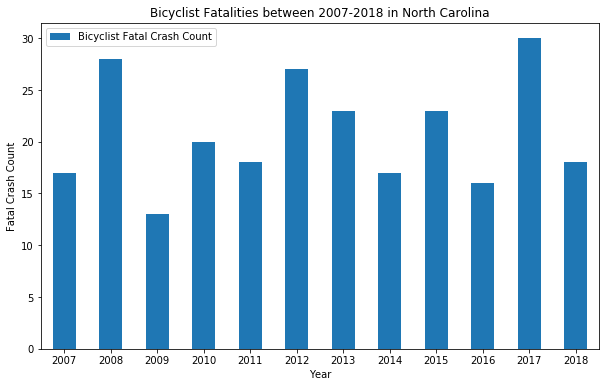

,Bicyclist Fatal Crash Count,Percent(%)
CrashYear,,
2017,30,12.0
2008,28,11.2
2012,27,10.8
2013,23,9.2
2015,23,9.2


In [76]:
# Fatal Crash count grouped by Crash year
biker_killed_by_year = biker_killed.groupby(["CrashYear"])["geo_point_2d"].count()
# biker_killed_by_year

biker_killed_by_year_df = pd.DataFrame(biker_killed_by_year)
biker_killed_by_year_df.rename(columns = {"geo_point_2d": "Bicyclist Fatal Crash Count"}, inplace = True)


mean_biker_killed_by_year = round(biker_killed_by_year_df["Bicyclist Fatal Crash Count"].mean(), 2)
total_biker_killed = round(biker_killed_by_year_df["Bicyclist Fatal Crash Count"].sum(), 2)

biker_killed_by_year_df["Percent(%)"] = ""

for row in range(len(biker_killed_by_year_df)):
    biker_killed_by_year_df["Percent(%)"] = round((biker_killed_by_year_df["Bicyclist Fatal Crash Count"] / total_biker_killed)*100, 2) 
    
print(f"Total Fatal Crashes leading to Death of Bicyclist: {total_biker_killed}")
print(f"Average Fatal Crashes leading to Death of Bicyclist (2007-2018): {mean_biker_killed_by_year}")

# Create a bar plot for fatal crashes over time
ax = biker_killed_by_year_df.plot(kind='bar', y = "Bicyclist Fatal Crash Count", 
                                  figsize = (10,6), subplots = True, rot=0)

plt.title("Bicyclist Fatalities between 2007-2018 in North Carolina")
plt.xlabel("Year")
plt.ylabel("Fatal Crash Count")

# Save the bar plot for crashes over time
plt.savefig("Output/BikerKilledOverTime.png")

# Display the bar plot for crashes over time
plt.show()

biker_killed_by_year_df.sort_values(by="Bicyclist Fatal Crash Count", ascending=False).head()

Total Fatal Crashes leading to Death of Bicyclist: 250
Average Fatal Crashes leading to Death of Bicyclist (2007-2018): 20.83


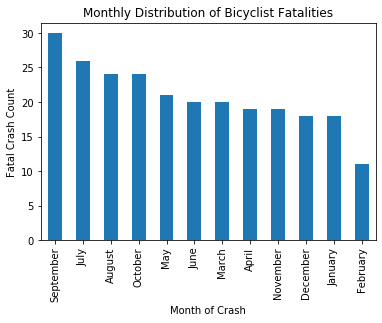

,Bicyclist Fatal Crash Count,Percent(%)
CrashMonth,,
September,30,12.0
July,26,10.4
August,24,9.6
October,24,9.6
May,21,8.4
June,20,8.0
March,20,8.0
April,19,7.6
November,19,7.6


In [74]:
# Bikers Fatal Crash count grouped by Crash Month
biker_killed_by_crashmonth = biker_killed.groupby(["CrashMonth"])["geo_point_2d"].count()


biker_killed_by_crashmonth_df = pd.DataFrame(biker_killed_by_crashmonth)
biker_killed_by_crashmonth_df.rename(columns = {"geo_point_2d": "Bicyclist Fatal Crash Count"}, inplace = True)
biker_killed_by_crashmonth_df = biker_killed_by_crashmonth_df.sort_values(by = "Bicyclist Fatal Crash Count", ascending=False)

mean_biker_killed_by_crashmonth = round(biker_killed_by_crashmonth_df["Bicyclist Fatal Crash Count"].mean(), 2)
total_biker_killed_by_crashmonth = round(biker_killed_by_crashmonth_df["Bicyclist Fatal Crash Count"].sum(), 2)

biker_killed_by_crashmonth_df["Percent(%)"] = ""

for row in range(len(biker_killed_by_crashmonth_df)):
    biker_killed_by_crashmonth_df["Percent(%)"] = round((biker_killed_by_crashmonth_df["Bicyclist Fatal Crash Count"] / total_biker_killed_by_crashmonth)*100, 2) 
    
print(f"Total Fatal Crashes leading to Death of Bicyclist: {total_biker_killed_by_crashmonth}")
print(f"Average Fatal Crashes leading to Death of Bicyclist (2007-2018): {mean_biker_killed_by_crashmonth}")

# Create a pie plot for fatal crashes by Crash Month
fig, ax1 = plt.subplots()
ax1 = biker_killed_by_crashmonth_df["Bicyclist Fatal Crash Count"].plot(kind='bar', figsize = (40,40), subplots=True)
plt.title("Monthly Distribution of Bicyclist Fatalities")
plt.xlabel("Month of Crash")
plt.ylabel("Fatal Crash Count")
# Save the pie plot for fatal crashes by Crash Month
plt.savefig("Output/BikerKilledCrashMonthAnalysis.png")

# Display the pie plot for fatal crashes by Crash Month
plt.show()

biker_killed_by_crashmonth_df


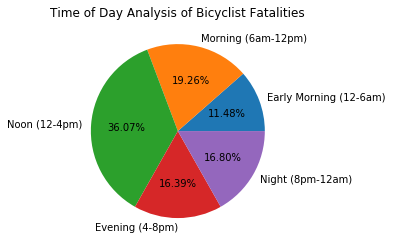

,Bicyclist Fatal Crash Count
Time of Day,
Noon (12-4pm),88
Morning (6am-12pm),47
Night (8pm-12am),41
Evening (4-8pm),40
Early Morning (12-6am),28


In [66]:
# Bikers Fatal Crash count grouped by Time of Day
biker_killed_by_timeofday = biker_killed.groupby(["Time of Day"])["geo_point_2d"].count()


biker_killed_by_timeofday_df = pd.DataFrame(biker_killed_by_timeofday)
biker_killed_by_timeofday_df.rename(columns = {"geo_point_2d": "Bicyclist Fatal Crash Count"}, inplace = True)

# Create a pie plot for fatal crashes by Time of Day
fig, ax1 = plt.subplots()
ax1 = biker_killed_by_timeofday_df["Bicyclist Fatal Crash Count"].plot(kind='pie', autopct = "%.2f%%", figsize = (40,40), subplots=True)
plt.title("Time of Day Analysis of Bicyclist Fatalities")
plt.axis("off") # remove the axis labels

# Save the pie plot for fatal crashes by Time of Day
plt.savefig("Output/BikerKilledTimeofDayAnalysis.png")

# Display the pie plot for fatal crashes by Time of Day
plt.show()

biker_killed_by_timeofday_df.sort_values(by = "Bicyclist Fatal Crash Count", ascending=False)

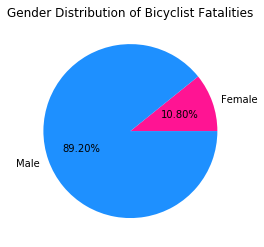

,Bicyclist Fatal Crash Count
BikeSex,
Male,223
Female,27


In [168]:
# Bikers Fatal Crash count grouped by Gender
biker_killed_by_gender = biker_killed.groupby(["BikeSex"])["geo_point_2d"].count()


biker_killed_by_gender_df = pd.DataFrame(biker_killed_by_gender)
biker_killed_by_gender_df.rename(columns = {"geo_point_2d": "Bicyclist Fatal Crash Count"}, inplace = True)

# Create a pie plot for fatal crashes by gender
fig, ax1 = plt.subplots()
colors = ("deeppink", "dodgerblue")
ax1 = biker_killed_by_gender_df["Bicyclist Fatal Crash Count"].plot(kind='pie', colors=colors, autopct = "%.2f%%", figsize = (40,40), subplots=True)
plt.title("Gender Distribution of Bicyclist Fatalities")
plt.xlabel("")
plt.ylabel("")

# Save the pie plot for fatal crashes by gender
plt.savefig("Output/BikerKilledGenderAnalysis.png")

# Display the pie plot for fatal crashes by gender
plt.show()

biker_killed_by_gender_df.sort_values(by = "Bicyclist Fatal Crash Count", ascending=False)

Total Fatal Crashes leading to Death of Bicyclist: 250
Average Fatal Crashes leading to Death of Bicyclist (2007-2018): 22.73


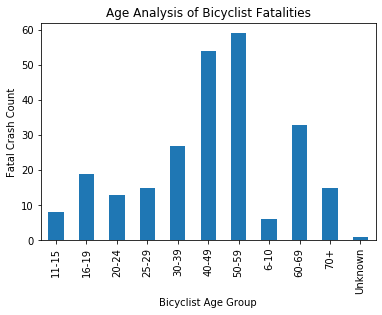

,Bicyclist Fatal Crash Count,Percent(%)
BikeAgeGrp,,
11-15,8,100.0
16-19,19,100.0
20-24,13,100.0
25-29,15,100.0
30-39,27,100.0
40-49,54,100.0
50-59,59,100.0
6-10,6,100.0
60-69,33,100.0


In [77]:
# Bikers Fatal Crash count grouped by Bikers Age group
biker_killed_by_agegroup = biker_killed.groupby(["BikeAgeGrp"])["geo_point_2d"].count()


biker_killed_by_agegroup_df = pd.DataFrame(biker_killed_by_agegroup)
biker_killed_by_agegroup_df.rename(columns = {"geo_point_2d": "Bicyclist Fatal Crash Count"}, inplace = True)
# biker_killed_by_agegroup_df = biker_killed_by_agegroup_df.sort_values(by = "Bicyclist Fatal Crash Count", ascending=False)

mean_biker_killed_by_agegroup = round(biker_killed_by_agegroup_df["Bicyclist Fatal Crash Count"].mean(), 2)
total_biker_killed_by_agegroup = round(biker_killed_by_agegroup_df["Bicyclist Fatal Crash Count"].sum(), 2)

biker_killed_by_agegroup_df["Percent(%)"] = ""

for row in range(len(biker_killed_by_agegroup_df)):
    biker_killed_by_agegroup_df["Percent(%)"] = round((biker_killed_by_agegroup_df["Bicyclist Fatal Crash Count"] / biker_killed_by_agegroup)*100, 2) 
    
print(f"Total Fatal Crashes leading to Death of Bicyclist: {total_biker_killed_by_agegroup}")
print(f"Average Fatal Crashes leading to Death of Bicyclist (2007-2018): {mean_biker_killed_by_agegroup}")

# Create a pie plot for fatal crashes by Bikers Age group
fig, ax1 = plt.subplots()
ax1 = biker_killed_by_agegroup_df["Bicyclist Fatal Crash Count"].plot(kind='bar', figsize = (40,40), subplots=True)
plt.title("Age Analysis of Bicyclist Fatalities")
plt.xlabel("Bicyclist Age Group")
plt.ylabel("Fatal Crash Count")
# Save the pie plot for fatal crashes by Bikers Age group
plt.savefig("Output/BikerKilledAgeAnalysis.png")

# Display the pie plot for fatal crashes by Bikers Age group
plt.show()

biker_killed_by_agegroup_df

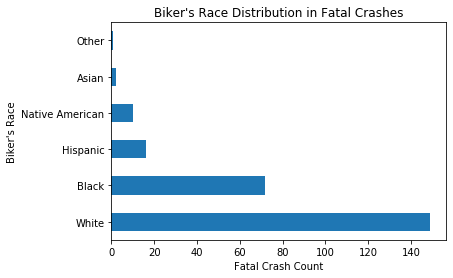

,Bicyclist Fatal Crash Count,Percent(%)
BikeRace,,
White,149,59.6
Black,72,28.8
Hispanic,16,6.4
Native American,10,4.0
Asian,2,0.8
Other,1,0.4


In [165]:
# Bikers Fatal Crash count grouped by Biker Race
biker_killed_by_bikerrace = biker_killed.groupby(["BikeRace"])["geo_point_2d"].count()

biker_killed_by_bikerrace_df = pd.DataFrame(biker_killed_by_bikerrace)
biker_killed_by_bikerrace_df.rename(columns = {"geo_point_2d": "Bicyclist Fatal Crash Count"}, inplace = True)
biker_killed_by_bikerrace_df = biker_killed_by_bikerrace_df.sort_values(by = "Bicyclist Fatal Crash Count", ascending=False)

total_biker_killed_by_bikerrace = round(biker_killed_by_bikerrace_df["Bicyclist Fatal Crash Count"].sum(), 2)

biker_killed_by_bikerrace_df["Percent(%)"] = ""

for row in range(len(biker_killed_by_bikerrace_df)):
    biker_killed_by_bikerrace_df["Percent(%)"] = round((biker_killed_by_bikerrace_df["Bicyclist Fatal Crash Count"] / total_biker_killed_by_bikerrace)*100, 2) 
    
# Create a pie plot for fatal crashes by Biker Race
fig, ax1 = plt.subplots()
ax1 = biker_killed_by_bikerrace_df["Bicyclist Fatal Crash Count"].plot(kind='barh', figsize = (60,40), subplots=True)
plt.title("Biker's Race Distribution in Fatal Crashes")
plt.ylabel("Biker's Race")
plt.xlabel("Fatal Crash Count")

# Save the pie plot for fatal crashes by Biker Race
plt.savefig("Output/BikerKilledbyBikerRace.png")

# Display the pie plot for fatal crashes by Biker Race
plt.show()

biker_killed_by_bikerrace_df

Total Fatal Crashes leading to Death of Bicyclist: 250
Average Fatal Crashes leading to Death of Bicyclist (2007-2018): 6.58


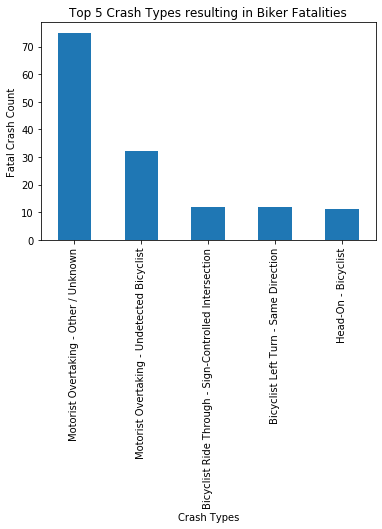

,Bicyclist Fatal Crash Count,Percent(%)
CrashType,,
Motorist Overtaking - Other / Unknown,75,30.0
Motorist Overtaking - Undetected Bicyclist,32,12.8
Bicyclist Ride Through - Sign-Controlled Intersection,12,4.8
Bicyclist Left Turn - Same Direction,12,4.8
Head-On - Bicyclist,11,4.4


In [93]:
# Bikers Fatal Crash count grouped by Crash Type
biker_killed_by_crashtype = biker_killed.groupby(["CrashType"])["geo_point_2d"].count()


biker_killed_by_crashtype_df = pd.DataFrame(biker_killed_by_crashtype)
biker_killed_by_crashtype_df.rename(columns = {"geo_point_2d": "Bicyclist Fatal Crash Count"}, inplace = True)
biker_killed_by_crashtype_df = biker_killed_by_crashtype_df.sort_values(by = "Bicyclist Fatal Crash Count", ascending=False)

mean_biker_killed_by_crashtype = round(biker_killed_by_crashtype_df["Bicyclist Fatal Crash Count"].mean(), 2)
total_biker_killed_by_crashtype = round(biker_killed_by_crashtype_df["Bicyclist Fatal Crash Count"].sum(), 2)

biker_killed_by_crashtype_df["Percent(%)"] = ""

for row in range(len(biker_killed_by_crashtype_df)):
    biker_killed_by_crashtype_df["Percent(%)"] = round((biker_killed_by_crashtype_df["Bicyclist Fatal Crash Count"] / total_biker_killed_by_crashtype)*100, 2) 
    
print(f"Total Fatal Crashes leading to Death of Bicyclist: {total_biker_killed_by_crashtype}")
print(f"Average Fatal Crashes leading to Death of Bicyclist (2007-2018): {mean_biker_killed_by_crashtype}")

top5_biker_killed_by_crashtype_df = biker_killed_by_crashtype_df.head()

# Create a pie plot for fatal crashes by Bikers Age group
fig, ax1 = plt.subplots()
ax1 = top5_biker_killed_by_crashtype_df["Bicyclist Fatal Crash Count"].plot(kind='bar', figsize = (40,40), subplots=True)
plt.title("Top 5 Crash Types resulting in Biker Fatalities")
plt.xlabel("Crash Types")
plt.ylabel("Fatal Crash Count")
# Save the pie plot for fatal crashes by Bikers Age group
plt.savefig("Output/BikerKilledbyCrashTypeTop5.png")

# Display the pie plot for fatal crashes by Bikers Age group
plt.show()

top5_biker_killed_by_crashtype_df

Total Fatal Crashes leading to Death of Bicyclist: 250


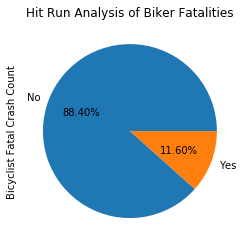

,Bicyclist Fatal Crash Count,Percent(%)
HitRun,,
No,221,88.4
Yes,29,11.6


In [110]:
# Bikers Fatal Crash count grouped by HitnRun
biker_killed_by_HitRun = biker_killed.groupby(["HitRun"])["geo_point_2d"].count()


biker_killed_by_HitRun_df = pd.DataFrame(biker_killed_by_HitRun)
biker_killed_by_HitRun_df.rename(columns = {"geo_point_2d": "Bicyclist Fatal Crash Count"}, inplace = True)
biker_killed_by_HitRun_df = biker_killed_by_HitRun_df.sort_values(by = "Bicyclist Fatal Crash Count", ascending=False)

mean_biker_killed_by_HitRun = round(biker_killed_by_HitRun_df["Bicyclist Fatal Crash Count"].mean(), 2)
total_biker_killed_by_HitRun = round(biker_killed_by_HitRun_df["Bicyclist Fatal Crash Count"].sum(), 2)

biker_killed_by_HitRun_df["Percent(%)"] = ""

for row in range(len(biker_killed_by_HitRun_df)):
    biker_killed_by_HitRun_df["Percent(%)"] = round((biker_killed_by_HitRun_df["Bicyclist Fatal Crash Count"] / total_biker_killed_by_HitRun)*100, 2) 
    
print(f"Total Fatal Crashes leading to Death of Bicyclist: {total_biker_killed_by_HitRun}")

# Create a pie plot for fatal crashes by HitRun
fig, ax1 = plt.subplots()
ax1 = biker_killed_by_HitRun_df["Bicyclist Fatal Crash Count"].plot(kind='pie', autopct = "%.2f%%", figsize = (40,40), subplots=True)
plt.title("Hit Run Analysis of Biker Fatalities")

# Save the pie plot for fatal crashes by HitRun
plt.savefig("Output/BikerKilledbyHitRun.png")

# Display the pie plot for fatal crashes by HitRun
plt.show()

biker_killed_by_HitRun_df

Average Crashes/County: 2.5
Total fatal crashes in top 10 counties: 116


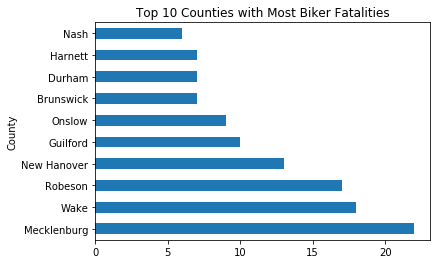

,Bicyclist Fatal Crash Count,Percent(%),Average Biker Fatalities
County,,,
Mecklenburg,22,8.8,2.00
Wake,18,7.2,1.64
Robeson,17,6.8,1.55
New Hanover,13,5.2,1.18
Guilford,10,4.0,0.91
Onslow,9,3.6,0.82
Brunswick,7,2.8,0.64
Durham,7,2.8,0.64
Harnett,7,2.8,0.64


In [174]:
# Bikers Fatal Crash count grouped by County
biker_killed_by_county = biker_killed.groupby(["County"])["geo_point_2d"].count()

biker_killed_by_county_df = pd.DataFrame(biker_killed_by_county)
biker_killed_by_county_df.rename(columns = {"geo_point_2d": "Bicyclist Fatal Crash Count"}, inplace = True)
biker_killed_by_county_df = biker_killed_by_county_df.sort_values(by = "Bicyclist Fatal Crash Count", ascending=False)

sum=round(biker_killed_by_county_df["Bicyclist Fatal Crash Count"].sum(), 2)
avg = sum/county_count
print(f"Average Crashes/County: {avg}")

biker_killed_by_county_df["Percent(%)"] = ""

for row in range(len(biker_killed_by_county_df)):
    biker_killed_by_county_df["Percent(%)"] = round((biker_killed_by_county_df["Bicyclist Fatal Crash Count"] / total_biker_killed_by_county)*100, 2) 
    biker_killed_by_county_df["Average Biker Fatalities"] = round((biker_killed_by_county_df["Bicyclist Fatal Crash Count"] / 11), 2)

top10_biker_killed_by_county_df = biker_killed_by_county_df.head(10)

top10sum=round(top10_biker_killed_by_county_df["Bicyclist Fatal Crash Count"].sum(), 2)
print(f"Total fatal crashes in top 10 counties: {top10sum}")


# Create a pie plot for fatal crashes by county
fig, ax1 = plt.subplots()
ax1 = top5_biker_killed_by_county_df["Bicyclist Fatal Crash Count"].plot(kind='barh', figsize = (60,40), subplots=True)
plt.title("Top 10 Counties with Most Biker Fatalities")


# Save the pie plot for fatal crashes by county
plt.savefig("Output/Top5BikerKilledbyCounty.png")

# Display the pie plot for fatal crashes by county
plt.show()

top5_biker_killed_by_county_df

Average Crashes/County: 0.764525993883792
Total fatal crashes in top 10 counties: 194


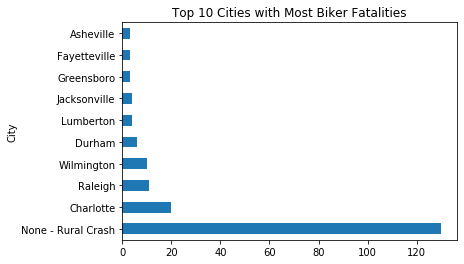

,Bicyclist Fatal Crash Count,Percent(%),Average Biker Fatalities
City,,,
None - Rural Crash,130,52.0,11.82
Charlotte,20,8.0,1.82
Raleigh,11,4.4,1.00
Wilmington,10,4.0,0.91
Durham,6,2.4,0.55
Lumberton,4,1.6,0.36
Jacksonville,4,1.6,0.36
Greensboro,3,1.2,0.27
Fayetteville,3,1.2,0.27


In [173]:
# Bikers Fatal Crash count grouped by City
biker_killed_by_city = biker_killed.groupby(["City"])["geo_point_2d"].count()

biker_killed_by_city_df = pd.DataFrame(biker_killed_by_city)
biker_killed_by_city_df.rename(columns = {"geo_point_2d": "Bicyclist Fatal Crash Count"}, inplace = True)
biker_killed_by_city_df = biker_killed_by_city_df.sort_values(by = "Bicyclist Fatal Crash Count", ascending=False)

total_biker_killed_by_city=round(biker_killed_by_city_df["Bicyclist Fatal Crash Count"].sum(), 2)
avg_biker_killed_by_city = total_biker_killed_by_city/city_count
print(f"Average Crashes/County: {avg_biker_killed_by_city}")

biker_killed_by_city_df["Percent(%)"] = ""

for row in range(len(biker_killed_by_city_df)):
    biker_killed_by_city_df["Percent(%)"] = round((biker_killed_by_city_df["Bicyclist Fatal Crash Count"] / total_biker_killed_by_city)*100, 2) 
    biker_killed_by_city_df["Average Biker Fatalities"] = round((biker_killed_by_city_df["Bicyclist Fatal Crash Count"] / 11), 2)

top10_biker_killed_by_city_df = biker_killed_by_city_df.head(10)

top10sum=round(top10_biker_killed_by_city_df["Bicyclist Fatal Crash Count"].sum(), 2)
print(f"Total fatal crashes in top 10 counties: {top10sum}")


# Create a pie plot for fatal crashes by City
fig, ax1 = plt.subplots()
ax1 = top10_biker_killed_by_city_df["Bicyclist Fatal Crash Count"].plot(kind='barh', figsize = (60,40), subplots=True)
plt.title("Top 10 Cities with Most Biker Fatalities")


# Save the pie plot for fatal crashes by City
plt.savefig("Output/Top5BikerKilledbyCity.png")

# Display the pie plot for fatal crashes by City
plt.show()

top10_biker_killed_by_city_df

In [104]:
top5_avg_biker_killed_by_county_df = biker_killed_by_county_df.sort_values(by = "Average Biker Fatalities", ascending=False)
top5_avg_biker_killed_by_county_df

,Bicyclist Fatal Crash Count,Percent(%),Average Biker Fatalities
County,,,
Mecklenburg,22,8.8,2.00
Wake,18,7.2,1.64
Robeson,17,6.8,1.55
New Hanover,13,5.2,1.18
Guilford,10,4.0,0.91
...,...,...,...
Wilkes,1,0.4,0.09
Stokes,1,0.4,0.09
Swain,1,0.4,0.09


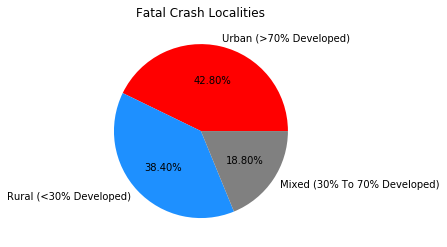

,Bicyclist Fatal Crash Count,Percent(%)
Locality,,
Urban (>70% Developed),107,42.8
Rural (<30% Developed),96,38.4
Mixed (30% To 70% Developed),47,18.8


In [181]:
# Bikers Fatal Crash count grouped by Locality
biker_killed_by_locality = biker_killed.groupby(["Locality"])["geo_point_2d"].count()

biker_killed_by_locality_df = pd.DataFrame(biker_killed_by_locality)
biker_killed_by_locality_df.rename(columns = {"geo_point_2d": "Bicyclist Fatal Crash Count"}, inplace = True)
biker_killed_by_locality_df = biker_killed_by_locality_df.sort_values(by = "Bicyclist Fatal Crash Count", ascending=False)

total_biker_killed_by_locality = round(biker_killed_by_locality_df["Bicyclist Fatal Crash Count"].sum(), 2)

biker_killed_by_locality_df["Percent(%)"] = ""

for row in range(len(biker_killed_by_locality_df)):
    biker_killed_by_locality_df["Percent(%)"] = round((biker_killed_by_locality_df["Bicyclist Fatal Crash Count"] / total_biker_killed_by_locality)*100, 2) 
    
# Create a pie plot for fatal crashes by Locality

colors=("red", "dodgerblue", "gray")
fig, ax1 = plt.subplots()
ax1 = biker_killed_by_locality_df["Bicyclist Fatal Crash Count"].plot(kind='pie', colors=colors,autopct = "%.2f%%", figsize = (60,40), subplots=True)
plt.title("Fatal Crash Localities")
plt.xlabel("")
plt.ylabel("")

# Save the pie plot for fatal crashes by Locality
plt.savefig("Output/BikerKilledbyLocality.png")

# Display the pie plot for fatal crashes by Locality
plt.show()

biker_killed_by_locality_df

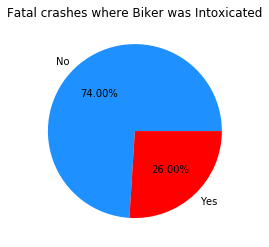

,Bicyclist Fatal Crash Count,Percent(%)
Biker Intox.,,
No,185,74.0
Yes,65,26.0


In [151]:
# Bikers Fatal Crash count grouped by Biker Intoxication
biker_killed_by_bikerintox = biker_killed.groupby(["Biker Intox."])["geo_point_2d"].count()

biker_killed_by_bikerintox_df = pd.DataFrame(biker_killed_by_bikerintox)
biker_killed_by_bikerintox_df.rename(columns = {"geo_point_2d": "Bicyclist Fatal Crash Count"}, inplace = True)
biker_killed_by_bikerintox_df = biker_killed_by_bikerintox_df.sort_values(by = "Bicyclist Fatal Crash Count", ascending=False)

total_biker_killed_by_bikerintox = round(biker_killed_by_bikerintox_df["Bicyclist Fatal Crash Count"].sum(), 2)

biker_killed_by_bikerintox_df["Percent(%)"] = ""

for row in range(len(biker_killed_by_bikerintox_df)):
    biker_killed_by_bikerintox_df["Percent(%)"] = round((biker_killed_by_bikerintox_df["Bicyclist Fatal Crash Count"] / total_biker_killed_by_bikerintox)*100, 2) 
    
# Create a pie plot for fatal crashes by Intoxication

colors=("dodgerblue", "red")
fig, ax1 = plt.subplots()
ax1 = biker_killed_by_bikerintox_df["Bicyclist Fatal Crash Count"].plot(kind='pie', colors=colors,autopct = "%.2f%%", figsize = (60,40), subplots=True)
plt.title("Fatal crashes where Biker was Intoxicated")
plt.xlabel("")
plt.ylabel("")

# Save the pie plot for fatal crashes by Intoxication
plt.savefig("Output/BikerKilledbyBikerIntoxication.png")

# Display the pie plot for fatal crashes by Intoxication
plt.show()

biker_killed_by_bikerintox_df

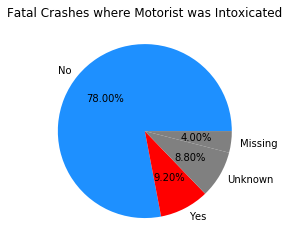

,Bicyclist Fatal Crash Count,Percent(%)
DrvrAlcFlg,,
No,195,78.0
Yes,23,9.2
Unknown,22,8.8
Missing,10,4.0


In [150]:
# Bikers Fatal Crash count grouped by Drivers Intoxication
biker_killed_by_motoristintox = biker_killed.groupby(["DrvrAlcFlg"])["geo_point_2d"].count()

biker_killed_by_motoristintox_df = pd.DataFrame(biker_killed_by_motoristintox)
biker_killed_by_motoristintox_df.rename(columns = {"geo_point_2d": "Bicyclist Fatal Crash Count"}, inplace = True)

biker_killed_by_motoristintox_df = biker_killed_by_motoristintox_df.sort_values(by = "Bicyclist Fatal Crash Count", ascending=False)

total_biker_killed_by_motoristintox = round(biker_killed_by_motoristintox_df["Bicyclist Fatal Crash Count"].sum(), 2)

biker_killed_by_motoristintox_df["Percent(%)"] = ""

for row in range(len(biker_killed_by_motoristintox_df)):
    biker_killed_by_motoristintox_df["Percent(%)"] = round((biker_killed_by_motoristintox_df["Bicyclist Fatal Crash Count"] / total_biker_killed_by_motoristintox)*100, 2) 
    
# Create a pie plot for fatal crashes by Drivers Intoxication
fig, ax1 = plt.subplots()
colors = ("dodgerblue", "red", "gray", "grey")
ax1 = biker_killed_by_motoristintox_df["Bicyclist Fatal Crash Count"].plot(kind='pie', colors=colors, autopct = "%.2f%%", figsize = (60,40), subplots=True)
plt.title("Fatal Crashes where Motorist was Intoxicated")
plt.xlabel("")
plt.ylabel("")

# Save the pie plot for fatal crashes by Drivers Intoxication
plt.savefig("Output/BikerKilledbyMotoristIntoxication.png")

# Display the pie plot for fatal crashes by Intoxication
plt.show()

biker_killed_by_motoristintox_df

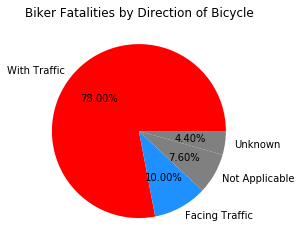

,Bicyclist Fatal Crash Count,Percent(%)
BikeDir,,
With Traffic,195,78.0
Facing Traffic,25,10.0
Not Applicable,19,7.6
Unknown,11,4.4


In [153]:
# Bikers Fatal Crash count grouped by Biker Direction
biker_killed_by_bikedir = biker_killed.groupby(["BikeDir"])["geo_point_2d"].count()

biker_killed_by_bikedir_df = pd.DataFrame(biker_killed_by_bikedir)
biker_killed_by_bikedir_df.rename(columns = {"geo_point_2d": "Bicyclist Fatal Crash Count"}, inplace = True)
biker_killed_by_bikedir_df = biker_killed_by_bikedir_df.sort_values(by = "Bicyclist Fatal Crash Count", ascending=False)

total_biker_killed_by_bikedir = round(biker_killed_by_bikedir_df["Bicyclist Fatal Crash Count"].sum(), 2)

biker_killed_by_bikedir_df["Percent(%)"] = ""

for row in range(len(biker_killed_by_bikedir_df)):
    biker_killed_by_bikedir_df["Percent(%)"] = round((biker_killed_by_bikedir_df["Bicyclist Fatal Crash Count"] / total_biker_killed_by_bikedir)*100, 2) 
    
# Create a pie plot for fatal crashes by Intoxication
fig, ax1 = plt.subplots()
colors = ("red", "dodgerblue", "gray", "grey")
ax1 = biker_killed_by_bikedir_df["Bicyclist Fatal Crash Count"].plot(kind='pie', colors=colors, autopct = "%.2f%%", figsize = (60,40), subplots=True)
plt.title("Biker Fatalities by Direction of Bicycle")
plt.xlabel("")
plt.ylabel("")

# Save the pie plot for fatal crashes by Intoxication
plt.savefig("Output/BikerKilledbyBikeDirection.png")

# Display the pie plot for fatal crashes by Intoxication
plt.show()

biker_killed_by_bikedir_df

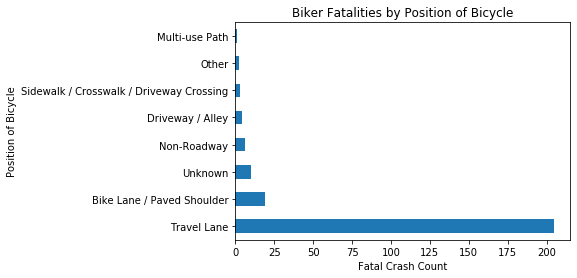

,Bicyclist Fatal Crash Count,Percent(%)
BikePos,,
Travel Lane,205,82.0
Bike Lane / Paved Shoulder,19,7.6
Unknown,10,4.0
Non-Roadway,6,2.4
Driveway / Alley,4,1.6
Sidewalk / Crosswalk / Driveway Crossing,3,1.2
Other,2,0.8
Multi-use Path,1,0.4


In [130]:
# Bikers Fatal Crash count grouped by Bike Position
biker_killed_by_bikepos = biker_killed.groupby(["BikePos"])["geo_point_2d"].count()

biker_killed_by_bikepos_df = pd.DataFrame(biker_killed_by_bikepos)
biker_killed_by_bikepos_df.rename(columns = {"geo_point_2d": "Bicyclist Fatal Crash Count"}, inplace = True)
biker_killed_by_bikepos_df = biker_killed_by_bikepos_df.sort_values(by = "Bicyclist Fatal Crash Count", ascending=False)

total_biker_killed_by_bikepos = round(biker_killed_by_bikepos_df["Bicyclist Fatal Crash Count"].sum(), 2)

biker_killed_by_bikepos_df["Percent(%)"] = ""

for row in range(len(biker_killed_by_bikepos_df)):
    biker_killed_by_bikepos_df["Percent(%)"] = round((biker_killed_by_bikepos_df["Bicyclist Fatal Crash Count"] / total_biker_killed_by_bikepos)*100, 2) 
    
# Create a pie plot for fatal crashes by Bike Position
fig, ax1 = plt.subplots()
ax1 = biker_killed_by_bikepos_df["Bicyclist Fatal Crash Count"].plot(kind='barh', figsize = (60,40), subplots=True)
plt.title("Biker Fatalities by Position of Bicycle")
plt.xlabel("Fatal Crash Count")
plt.ylabel("Position of Bicycle")

# Save the pie plot for fatal crashes by Bike Position
plt.savefig("Output/BikerKilledbyBikePosition.png")

# Display the pie plot for fatal crashes by Bike Position
plt.show()

biker_killed_by_bikepos_df

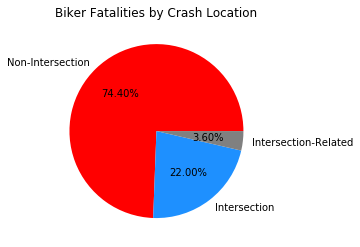

,Bicyclist Fatal Crash Count,Percent(%)
CrashLoc,,
Non-Intersection,186,74.4
Intersection,55,22.0
Intersection-Related,9,3.6


In [154]:
# Bikers Fatal Crash count grouped by Crash Location
biker_killed_by_crashloc = biker_killed.groupby(["CrashLoc"])["geo_point_2d"].count()

biker_killed_by_crashloc_df = pd.DataFrame(biker_killed_by_crashloc)
biker_killed_by_crashloc_df.rename(columns = {"geo_point_2d": "Bicyclist Fatal Crash Count"}, inplace = True)
biker_killed_by_crashloc_df = biker_killed_by_crashloc_df.sort_values(by = "Bicyclist Fatal Crash Count", ascending=False)

total_biker_killed_by_crashloc = round(biker_killed_by_crashloc_df["Bicyclist Fatal Crash Count"].sum(), 2)

biker_killed_by_crashloc_df["Percent(%)"] = ""

for row in range(len(biker_killed_by_crashloc_df)):
    biker_killed_by_crashloc_df["Percent(%)"] = round((biker_killed_by_crashloc_df["Bicyclist Fatal Crash Count"] / total_biker_killed_by_crashloc)*100, 2) 
    
# Create a pie plot for fatal crashes by Crash Location
fig, ax1 = plt.subplots()
colors = ("red", "dodgerblue", "gray", "grey")
ax1 = biker_killed_by_crashloc_df["Bicyclist Fatal Crash Count"].plot(kind='pie', colors=colors, autopct = "%.2f%%", figsize = (60,40), subplots=True)
plt.title("Biker Fatalities by Crash Location")
plt.xlabel("")
plt.ylabel("")

# Save the pie plot for fatal crashes by Crash Location
plt.savefig("Output/BikerKilledbyBikePosition.png")

# Display the pie plot for fatal crashes by Crash Location
plt.show()

biker_killed_by_crashloc_df

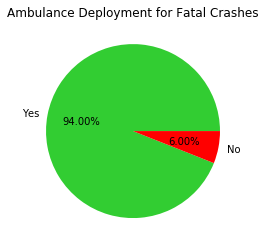

,Bicyclist Fatal Crash Count,Percent(%)
Ambulance,,
Yes,235,94.0
No,15,6.0


In [157]:
# Bikers Fatal Crash count grouped by Ambulance
biker_killed_by_amb = biker_killed.groupby(["Ambulance"])["geo_point_2d"].count()

biker_killed_by_amb_df = pd.DataFrame(biker_killed_by_amb)
biker_killed_by_amb_df.rename(columns = {"geo_point_2d": "Bicyclist Fatal Crash Count"}, inplace = True)
biker_killed_by_amb_df = biker_killed_by_amb_df.sort_values(by = "Bicyclist Fatal Crash Count", ascending=False)

total_biker_killed_by_amb = round(biker_killed_by_amb_df["Bicyclist Fatal Crash Count"].sum(), 2)

biker_killed_by_amb_df["Percent(%)"] = ""

for row in range(len(biker_killed_by_amb_df)):
    biker_killed_by_amb_df["Percent(%)"] = round((biker_killed_by_amb_df["Bicyclist Fatal Crash Count"] / total_biker_killed_by_amb)*100, 2) 
    
# Create a pie plot for fatal crashes by Ambulance
fig, ax1 = plt.subplots()
colors = ("limegreen", "red")
ax1 = biker_killed_by_amb_df["Bicyclist Fatal Crash Count"].plot(kind='pie', colors=colors, autopct = "%.2f%%", figsize = (60,40), subplots=True)
plt.title("Ambulance Deployment for Fatal Crashes")
plt.xlabel("")
plt.ylabel("")

# Save the pie plot for fatal crashes by Ambulance
plt.savefig("Output/BikerKilledbyAmbulance.png")

# Display the pie plot for fatal crashes by Ambulance
plt.show()

biker_killed_by_amb_df

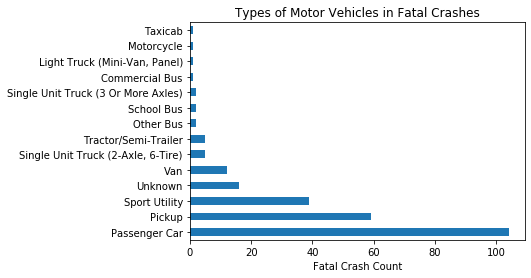

,Bicyclist Fatal Crash Count,Percent(%)
DrvrVehTyp,,
Passenger Car,104,41.6
Pickup,59,23.6
Sport Utility,39,15.6
Unknown,16,6.4
Van,12,4.8
"Single Unit Truck (2-Axle, 6-Tire)",5,2.0
Tractor/Semi-Trailer,5,2.0
Other Bus,2,0.8
School Bus,2,0.8


In [190]:
# Bikers Fatal Crash count grouped by type of Motor Vehicle 
biker_killed_by_vehtype = biker_killed.groupby(["DrvrVehTyp"])["geo_point_2d"].count()

biker_killed_by_vehtype_df = pd.DataFrame(biker_killed_by_vehtype)
biker_killed_by_vehtype_df.rename(columns = {"geo_point_2d": "Bicyclist Fatal Crash Count"}, inplace = True)
biker_killed_by_vehtype_df = biker_killed_by_vehtype_df.sort_values(by = "Bicyclist Fatal Crash Count", ascending=False)

total_biker_killed_by_vehtype = round(biker_killed_by_vehtype_df["Bicyclist Fatal Crash Count"].sum(), 2)

biker_killed_by_vehtype_df["Percent(%)"] = ""

for row in range(len(biker_killed_by_vehtype_df)):
    biker_killed_by_vehtype_df["Percent(%)"] = round((biker_killed_by_vehtype_df["Bicyclist Fatal Crash Count"] / total_biker_killed_by_vehtype)*100, 2) 
    
# Create a pie plot for fatal crashes by type of Motor Vehicle
fig, ax1 = plt.subplots()
ax1 = biker_killed_by_vehtype_df["Bicyclist Fatal Crash Count"].plot(kind='barh', figsize = (60,40), subplots=True)
plt.title("Types of Motor Vehicles in Fatal Crashes")
plt.xlabel("Fatal Crash Count")
plt.ylabel("")

# Save the pie plot for fatal crashes by type of Motor Vehicle
plt.savefig("Output/BikerKilledbyMotorvehicletype.png")

# Display the pie plot for fatal crashes by type of Motor Vehicle
plt.show()

biker_killed_by_vehtype_df

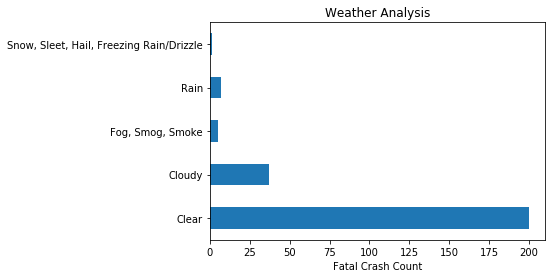

,Bicyclist Fatal Crash Count,Percent(%)
Weather,,
Clear,200,80.0
Cloudy,37,14.8
"Fog, Smog, Smoke",5,2.0
Rain,7,2.8
"Snow, Sleet, Hail, Freezing Rain/Drizzle",1,0.4


In [188]:
# Bikers Fatal Crash count grouped by Weather Condition 
biker_killed_by_weather = biker_killed.groupby(["Weather"])["geo_point_2d"].count()

biker_killed_by_weather_df = pd.DataFrame(biker_killed_by_weather)
biker_killed_by_weather_df.rename(columns = {"geo_point_2d": "Bicyclist Fatal Crash Count"}, inplace = True)
biker_killed_by_weathere_df = biker_killed_by_weather_df.sort_values(by = "Bicyclist Fatal Crash Count", ascending=False)

total_biker_killed_by_weather = round(biker_killed_by_weather_df["Bicyclist Fatal Crash Count"].sum(), 2)

biker_killed_by_weather_df["Percent(%)"] = ""

for row in range(len(biker_killed_by_weather_df)):
    biker_killed_by_weather_df["Percent(%)"] = round((biker_killed_by_weather_df["Bicyclist Fatal Crash Count"] / total_biker_killed_by_weather)*100, 2) 
    
# Create a pie plot for fatal crashes by type of Motor Vehicle
fig, ax1 = plt.subplots()
ax1 = biker_killed_by_weather_df["Bicyclist Fatal Crash Count"].plot(kind='barh', figsize = (60,40), subplots=True)
plt.title("Weather Analysis")
plt.xlabel("Fatal Crash Count")
plt.ylabel("")

# Save the pie plot for fatal crashes by type of Motor Vehicle
plt.savefig("Output/BikerKilledbyWeatherCondition.png")

# Display the pie plot for fatal crashes by type of Motor Vehicle
plt.show()

biker_killed_by_weather_df

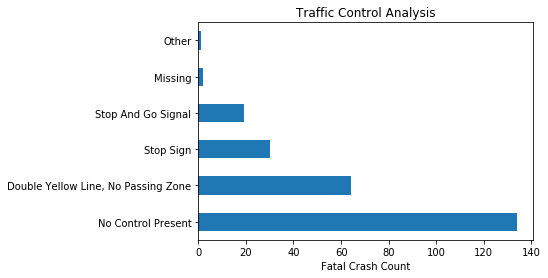

,Bicyclist Fatal Crash Count,Percent(%)
TraffCntrl,,
No Control Present,134,53.6
"Double Yellow Line, No Passing Zone",64,25.6
Stop Sign,30,12.0
Stop And Go Signal,19,7.6
Missing,2,0.8
Other,1,0.4


In [189]:
# Bikers Fatal Crash count grouped by Traffic Control 
biker_killed_by_trafficcontrol = biker_killed.groupby(["TraffCntrl"])["geo_point_2d"].count()

biker_killed_by_trafficcontrol_df = pd.DataFrame(biker_killed_by_trafficcontrol)
biker_killed_by_trafficcontrol_df.rename(columns = {"geo_point_2d": "Bicyclist Fatal Crash Count"}, inplace = True)
biker_killed_by_trafficcontrol_df = biker_killed_by_trafficcontrol_df.sort_values(by = "Bicyclist Fatal Crash Count", ascending=False)

total_biker_killed_by_trafficcontrol = round(biker_killed_by_trafficcontrol_df["Bicyclist Fatal Crash Count"].sum(), 2)

biker_killed_by_trafficcontrol_df["Percent(%)"] = ""

for row in range(len(biker_killed_by_trafficcontrol_df)):
    biker_killed_by_trafficcontrol_df["Percent(%)"] = round((biker_killed_by_trafficcontrol_df["Bicyclist Fatal Crash Count"] / total_biker_killed_by_trafficcontrol)*100, 2) 
    
# Create a pie plot for fatal crashes by type of Motor Vehicle
fig, ax1 = plt.subplots()
ax1 = biker_killed_by_trafficcontrol_df["Bicyclist Fatal Crash Count"].plot(kind='barh', figsize = (60,40), subplots=True)
plt.title("Traffic Control Analysis")
plt.xlabel("Fatal Crash Count")
plt.ylabel("")

# Save the pie plot for fatal crashes by type of Motor Vehicle
plt.savefig("Output/BikerKilledbyTrafficControl.png")

# Display the pie plot for fatal crashes by type of Motor Vehicle
plt.show()

biker_killed_by_trafficcontrol_df

In [20]:
# 

In [25]:
# Crashes by Locality
crashes_by_locality = crash_data.groupby(["Locality"])["geo_point_2d"].count()
crashes_by_locality

Locality
Mixed (30% To 70% Developed)    1568
Rural (<30% Developed)          1658
Urban (>70% Developed)          8040
Name: geo_point_2d, dtype: int64

In [26]:
# Crashes by Day of Week
crashes_by_weekday = crash_data.groupby(["Day of Week"])["geo_point_2d"].count()
crashes_by_weekday.sort_values(ascending=False)

Day of Week
Friday       1770
Thursday     1701
Wednesday    1697
Tuesday      1695
Monday       1624
Saturday     1503
Sunday       1276
Name: geo_point_2d, dtype: int64

## Bicycle Crash Hotspots in the State

In [175]:
from pprint import pprint

# Configure gmaps with API key
gmaps.configure(api_key=gkey)

crash_hotspots = crash_data.groupby(["City"]).agg({"City":"count"})
crash_hotspots.columns=["Crash Count"]
crash_hotspots.reset_index(inplace=True)

crash_hotspots["City Latitude"] = ""
crash_hotspots["City Longitude"] = ""

params = {"key": gkey}

for index, row in crash_hotspots.iterrows():
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    current_city = row["City"]
    state = "North Carolina"
    params["address"] = f"{current_city},{state}"
    jsonresponse = requests.get(base_url, params=params).json()
    #pprint(jsonresponse,indent =4)
    current_city_latitude = jsonresponse["results"][0]["geometry"]["location"]["lat"]
    current_city_longitude = jsonresponse["results"][0]["geometry"]["location"]["lng"]
    crash_hotspots.loc[index,"City Latitude"] = current_city_latitude
    crash_hotspots.loc[index,"City Longitude"] = current_city_longitude
    
crash_hotspots.head(60)

,City,Crash Count,City Latitude,City Longitude
0,Aberdeen,4,35.1315,-79.4295
1,Ahoskie,8,36.2868,-76.9847
2,Alamance,1,36.0351,-79.4859
3,Albemarle,16,35.3501,-80.2001
4,Alexander,1,35.6988,-82.6366
5,Alliance,2,35.1449,-76.8022
6,Andrews,4,35.2018,-83.8241
7,Angier,4,35.5071,-78.7392
8,Apex,38,35.7327,-78.8503
9,Arapahoe,1,35.0257,-76.8255


In [177]:
# Configure gmaps with API key
gmaps.configure(api_key=gkey)

locations = crash_hotspots[["City Latitude", "City Longitude"]].astype(float)
crash_count = crash_hotspots["Crash Count"].astype(float)

# Create a Crash Count Heatmap layer for each city
fig5 = gmaps.figure()
heat_layer = gmaps.heatmap_layer(locations, weights=crash_count, 
                                 dissipating=False, max_intensity=1000,
                                 point_radius = 0.10)
fig5.add_layer(heat_layer)
fig5

Figure(layout=FigureLayout(height='420px'))

In [178]:
crash_rate = crash_hotspots["Crash Count"].tolist()

# Create bank symbol layer
crash_layer = gmaps.symbol_layer(
    locations, fill_color='rgba(0, 150, 0, 0.4)',
    stroke_color='rgba(0, 0, 150, 0.4)', scale=2,
    info_box_content=[f"{City}" for City in crash_rate]
)
fig2 = gmaps.figure()
fig2.add_layer(crash_layer)

# Create a combined map
fig3 = gmaps.figure()
fig3.add_layer(heat_layer)
fig3.add_layer(crash_layer)
fig3

Figure(layout=FigureLayout(height='420px'))

In [31]:
killed = crash_data.loc[crash_data["CrashSevr"] == "K: Killed",:]
fatal_cities = killed.groupby("City")["geo_point_2d"].count()

#fatality_hotspots_by_county = killed.groupby("County")["geo_point_2d"].count()


fatal_cities_df = pd.DataFrame(fatal_cities)
fatal_cities_df.rename(columns={"geo_point_2d": "Fatal Crash Count"}, inplace = True)
fatal_cities_df = fatal_cities_df.sort_values(by=["Fatal Crash Count"], ascending=False)
fatal_cities_df.reset_index(inplace=True)


fatal_cities_df["City Latitude"] = ""
fatal_cities_df["City Longitude"] = ""

params = {"key": gkey}

for index, row in fatal_cities_df.iterrows():
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    current_city = row["City"]
    state = "North Carolina"
    params["address"] = f"{current_city},{state}"
    jsonresponse = requests.get(base_url, params=params).json()
    #pprint(jsonresponse,indent =4)
    current_city_latitude = jsonresponse["results"][0]["geometry"]["location"]["lat"]
    current_city_longitude = jsonresponse["results"][0]["geometry"]["location"]["lng"]
    fatal_cities_df.loc[index,"City Latitude"] = current_city_latitude
    fatal_cities_df.loc[index,"City Longitude"] = current_city_longitude
    
fatal_cities_df = fatal_cities_df.drop([0])
fatal_cities_df

,City,Fatal Crash Count,City Latitude,City Longitude
1,Charlotte,20,35.2271,-80.8431
2,Raleigh,11,35.7796,-78.6382
3,Wilmington,10,34.2104,-77.8868
4,Durham,6,35.994,-78.8986
5,Lumberton,5,34.6182,-79.0086
6,Fayetteville,4,35.0527,-78.8784
7,Jacksonville,4,34.7541,-77.4302
8,Greensboro,3,36.0726,-79.792
9,Asheville,3,35.5951,-82.5515
10,High Point,2,35.9557,-80.0053


In [32]:
# Configure gmaps with API key
gmaps.configure(api_key=gkey)

locations = fatal_cities_df[["City Latitude", "City Longitude"]].astype(float)
fatal_crash_count = fatal_cities_df["Fatal Crash Count"].astype(float)

# Create a Crash Count Heatmap layer for each city
fig = gmaps.figure()
fatal_heat_layer = gmaps.heatmap_layer(locations, weights=fatal_crash_count, 
                                 dissipating=False, max_intensity=5,
                                 point_radius = 0.10)
fig.add_layer(fatal_heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [33]:
fatal_crash_rate = fatal_cities_df["Fatal Crash Count"].tolist()

# Create bank symbol layer
fatal_crash_layer = gmaps.symbol_layer(locations, scale = 1)
fig = gmaps.figure()
fig.add_layer(fatal_crash_layer)

In [35]:
# Create a combined map
fig = gmaps.figure()
fig.add_layer(fatal_heat_layer)
fig.add_layer(fatal_crash_layer)
fig


Figure(layout=FigureLayout(height='420px'))

In [40]:
crashes = crash_data[["geo_point_2d", "County", "City"]]
crashes_df = crashes.groupby(["County"])["geo_point_2d"].count()
crashes_df.sort_values(ascending=False)


County
Wake           1500
Mecklenburg    1421
New Hanover     767
Guilford        741
Durham          539
               ... 
Tyrrell           3
Clay              3
Alexander         3
Mitchell          2
Alleghany         1
Name: geo_point_2d, Length: 100, dtype: int64